In [1]:
import os
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# 길이 조정 함수
def length_scaling(data, target_length=256):
    current_length = data.shape[0]
    
    scaling_factor = target_length / current_length
    scaled_data = np.zeros((target_length, data.shape[1]))

    for i in range(data.shape[1]):
        scaled_data[:, i] = np.interp(
            np.linspace(0, 1, target_length),
            np.linspace(0, 1, current_length),
            data[:, i]
        )

    return scaled_data


def df_rename(df):
    CM_list = ['CM7', 'CM8', 'CM9']
    
    for CM in CM_list:
        # 컬럼명 변경
        new_columns = {
            'CPC_LineB.CPC_PLCB.Global.' + CM + '_DATA_x.COM_PV_FP': 'FP', # Furnace Pressure
            'CPC_LineB.CPC_PLCB.Global.' + CM + '_DATA_x.COM_PV_CP': 'CP', # Chamber Pressure
            'CPC_LineB.CPC_PLCB.Global.' + CM + '_DATA_x.COM_PV_FT': 'Temperature',
            'CPC_LineB.CPC_PLCB.Global.' + CM + '_DATA_x.COM_PV_FCT': 'Coil Temperature', #코일 온도
            'CPC_LineB.CPC_PLCB.Global.' + CM + '_DATA_x.COM_PV_HEATER_L1': 'Coil T', #코일 압력 T
            'CPC_LineB.CPC_PLCB.Global.' + CM + '_DATA_x.COM_PV_HEATER_L2': 'Coil S', #코일 압력 S
            'CPC_LineB.CPC_PLCB.Global.' + CM + '_DATA_x.COM_PV_HEATER_L3': 'Coil R' #코일 압력 R
            }
        df = df.rename(columns=new_columns)
    
    return df

def df_normalize(df):
    normalized_df = (df - df.min()) / (df.max() - df.min())
    return normalized_df

def make_df(path):
    cols = ['FP', 'CP', 'Temperature', 'Coil Temperature', 'Coil T', 'Coil S', 'Coil R']
    df = []
    
    # 경로 내의 파일 및 폴더 확인
    for root, dirs, files in os.walk(path):
        # 확장자 .csv인 파일 선택
        csv_files = [file for file in files if file.endswith(".csv")]
        
        # csv 파일 처리
        for file in csv_files:
            file_path = os.path.join(root, file)
            
            # CSV 파일 읽고 추가
            csv_data = pd.read_csv(file_path)
            csv_data = df_rename(csv_data)
            csv_data = csv_data[cols].interpolate(method='linear') # 선형 보간
            csv_data = csv_data.dropna(axis=0).reset_index(drop=True)
            csv_data = df_normalize(csv_data)
            df.append(csv_data)
    
    # Pandas DataFrame => NumPy
    df_array = np.array([length_scaling(dataframe.values, 256) for dataframe in df if len(dataframe.values)])
        
    return df, df_array

In [4]:
class LSTMAutoEncoder(nn.Module):
    def __init__(self, num_layers, hidden_size, nb_feature, dropout=0, device=torch.device('cpu')):
        super(LSTMAutoEncoder, self).__init__()
        self.device = device
        self.encoder = Encoder(num_layers, hidden_size, nb_feature, dropout, device)
        self.decoder = Decoder(num_layers, hidden_size, nb_feature, dropout, device)

    def forward(self, input_seq):
        output = torch.zeros(size=input_seq.shape, dtype=torch.float)
        hidden_cell = self.encoder(input_seq)
        input_decoder = input_seq[:, -1, :].view(input_seq.shape[0], 1, input_seq.shape[2])
        for i in range(input_seq.shape[1] - 1, -1, -1):
            output_decoder, hidden_cell = self.decoder(input_decoder, hidden_cell)
            input_decoder = output_decoder
            output[:, i, :] = output_decoder[:, 0, :]
        return output


class Encoder(nn.Module):
    def __init__(self, num_layers, hidden_size, nb_feature, dropout, device):
        super(Encoder, self).__init__()

        self.input_size = nb_feature
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device

        self.lstm = nn.LSTM(input_size=nb_feature, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout, bias=True)

    def initHidden(self, batch_size):
        self.hidden_cell = (
            torch.randn((self.num_layers, batch_size, self.hidden_size), dtype=torch.float).to(self.device),
            torch.randn((self.num_layers, batch_size, self.hidden_size), dtype=torch.float).to(self.device)
        )

    def forward(self, input_seq):
        self.initHidden(input_seq.shape[0])
        _, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        return self.hidden_cell


class Decoder(nn.Module):
    def __init__(self, num_layers, hidden_size, nb_feature, dropout, device):
        super(Decoder, self).__init__()

        self.input_size = nb_feature
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device

        self.lstm = nn.LSTM(input_size=nb_feature, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout, bias=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=nb_feature)

    def forward(self, input_seq, hidden_cell):
        output, hidden_cell = self.lstm(input_seq, hidden_cell)
        output = self.linear(output)
        return output, hidden_cell

In [5]:
class LossCheckpoint:
    def __init__(self):
        self.losses = []

    def plot(self, log=False):
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(self.losses)), self.losses)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        if log:
            plt.yscale('log')
        plt.show()
        
class EarlyStopping:
    def __init__(self, patience=0):
        self.last_metrics = 10**8
        self.patience = patience
        self.patience_count = 0

    def check_training(self, metric):
        if metric < self.last_metrics:
            self.last_metrics = metric
            self.patience_count = 0
            return False
        elif (metric > self.last_metrics) & (self.patience_count < self.patience):
            self.patience_count += 1
            return False
        else:
            return True

In [6]:
class ModelManagement:
    def __init__(self, path, name_model):
        self.path = path
        self.last_metrics = 10**8
        self.name_model = name_model
        self.dict_model = None

    def save(self, model):
        torch.save(model.state_dict(), self.path + '%s' % self.name_model)

    def checkpoint(self, epoch, model, optimizer, loss):
        if self.last_metrics > loss:
            self.dict_model = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }
            self.last_metrics = loss

    def save_best_model(self):
        torch.save(self.dict_model, self.path + '%s_epoch_%d' % (self.name_model, self.dict_model['epoch']))

In [7]:
def create_dataset(df):
    temp = df.tolist()
    dataset = [torch.tensor(s).float() for s in temp]
    
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    
    return dataset, seq_len, n_features

In [8]:
def train(epoch, train_loader):
    model.train()
    train_loss = 0
    for id_batch, data in enumerate(train_loader):
        optimizer.zero_grad()
        # forward
        data = data.to(device)
        output = model.forward(data)
        loss = criterion(data, output.to(device))
        # backward
        loss.backward()
        train_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.3)
        optimizer.step()

        print('\r', 'Training [{}/{} ({:.0f}%)] \tLoss: {:.6f})]'.format(
            id_batch + 1, len(train_loader),
            (id_batch + 1) * 100 / len(train_loader),
            loss.item()), sep='', end='', flush=True)

    avg_loss = train_loss / len(train_loader)
    print('====> Epoch: {} Average loss: {:.6f}'.format(epoch, avg_loss))
    loss_checkpoint_train.losses.append(avg_loss)

In [9]:
def evaluate(loader, validation=False, epoch=0):
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for id_batch, data in enumerate(loader):
            data = data.to(device)
            output = model.forward(data)
            loss = criterion(data, output.to(device))
            eval_loss += loss.item()
        print('\r', 'Eval [{}/{} ({:.0f}%)] \tLoss: {:.6f})]'.format(
            id_batch + 1, len(loader),
            (id_batch + 1) * 100 / len(loader),
            loss.item()), sep='', end='', flush=True)
    avg_loss = eval_loss / len(loader)
    print('====> Validation Average loss: {:.6f}'.format(avg_loss))
    # Checkpoint
    if validation:
        loss_checkpoint_valid.losses.append(avg_loss)
        model_management.checkpoint(epoch, model, optimizer, avg_loss)
        return earlyStopping.check_training(avg_loss)

# Data Preparation

In [10]:
normal_path = '../data/conf/normal/'
down_path = '../data/conf/false/'
abnormal_path = '../data/conf/abnormal'

In [11]:
# Normal, Down, Abnormal 순
temp, normal_df = make_df(normal_path)
_,down_df = make_df(down_path)
_, abnormal_df = make_df(abnormal_path) 

print(normal_df.shape)
print(down_df.shape)
print(abnormal_df.shape)

(4071, 256, 7)
(716, 256, 7)
(146, 256, 7)


In [12]:
# Train:Valid:Test = 0.6:0.2:0.2 
# (Abnormal은 훈련하지 않기 때문에 Valid:Test=0.5:0.5)
train_normal_df, val_normal_df = train_test_split(normal_df, test_size=0.4, random_state=1209)
train_down_df, val_down_df = train_test_split(down_df, test_size = 0.4, random_state=1209)

val_normal_df, test_normal_df = train_test_split(val_normal_df, test_size=0.5, random_state=1209)
val_down_df, test_down_df = train_test_split(val_down_df, test_size = 0.5, random_state=1209)

val_abnormal_df, test_abnormal_df = train_test_split(abnormal_df, test_size = 0.5, random_state=1209)
# =============================================================================
train_normal_dataset, seq_len, n_features = create_dataset(train_normal_df)
train_down_dataset, _, _ = create_dataset(train_down_df)

val_normal_dataset, _, _ = create_dataset(val_normal_df)
val_down_dataset, _, _ = create_dataset(val_down_df)
val_abnormal_dataset, _, _ = create_dataset(val_abnormal_df)

test_normal_dataset, _, _ = create_dataset(test_normal_df)
test_down_dataset, _, _ = create_dataset(test_down_df)
test_abnormal_dataset, _, _ = create_dataset(test_abnormal_df)

In [13]:
print(len(train_normal_dataset), len(train_down_dataset))
print(len(val_normal_dataset), len(val_down_dataset), len(val_abnormal_dataset))
print(len(test_normal_dataset), len(test_down_dataset), len(test_abnormal_dataset))

2442 429
814 143 73
815 144 73


# Two-Stage Inference

In [14]:
hidden_size = 32
num_layers = 4
criterion = torch.nn.MSELoss()

# First Model
first_model = LSTMAutoEncoder(num_layers, hidden_size, n_features, device=device)
first_checkpoint = torch.load('../model/conf/first/lstm_32_4_(len256)_epoch_479')
first_model.load_state_dict(first_checkpoint['model_state_dict'])

# Second Model
second_model = LSTMAutoEncoder(num_layers, hidden_size, n_features, device=device)
second_checkpoint = torch.load('../model/conf/second/lstm_32_4_(len256)_epoch_288')
second_model.load_state_dict(second_checkpoint['model_state_dict'])

<All keys matched successfully>

In [15]:
first_model.to(device)
second_model.to(device)

LSTMAutoEncoder(
  (encoder): Encoder(
    (lstm): LSTM(7, 32, num_layers=4, batch_first=True)
  )
  (decoder): Decoder(
    (lstm): LSTM(7, 32, num_layers=4, batch_first=True)
    (linear): Linear(in_features=32, out_features=7, bias=True)
  )
)

## First Model Threshold

In [16]:
val_normal_loss = [0 for _ in range(len(val_normal_dataset))]
val_abnormal_loss = [0 for _ in range(len(val_abnormal_dataset))]

with torch.no_grad():
    for i in range(len(val_normal_dataset)):
        data = val_normal_dataset[i]
        data = data.unsqueeze(0).to(device)
        output = first_model.forward(data).to(device)
        loss = criterion(data, output)
        val_normal_loss[i] = loss

with torch.no_grad():
    for i in range(len(val_abnormal_dataset)):
        data = val_abnormal_dataset[i]
        data = data.unsqueeze(0).to(device)
        output = first_model.forward(data).to(device)
        loss = criterion(data, output)
        val_abnormal_loss[i] = loss

In [17]:
thresholds = np.arange(0, 0.15, 0.001)

accuracy_list = [0 for _ in range(len(thresholds))]
precision_list = [0 for _ in range(len(thresholds))]
recall_list = [0 for _ in range(len(thresholds))]
F1_list = [0 for _ in range(len(thresholds))]

for i in range(len(thresholds)):
    threshold = thresholds[i]
    val_abnomal = 0
    test_abnomal = 0
    
    for loss in val_normal_loss:
        if loss > threshold:
            val_abnomal += 1
    
    for loss in val_abnormal_loss:
        if loss > threshold:
            test_abnomal += 1
            
    TP = test_abnomal
    FP = val_abnomal
    TN = len(val_normal_dataset)-val_abnomal
    FN = len(val_abnormal_dataset)-test_abnomal
    
    accuracy = (TP+TN) / (TP+FP+TN+FN)
    precision = TP / (TP+FP)
    recall = TP / (TP+FN)
    F1 = 2 / (1/precision + 1/recall)

    accuracy_list[i] = accuracy
    precision_list[i] = precision
    recall_list[i] = recall
    F1_list[i] = F1

In [18]:
min_dist = 10
idx = 0

for i in range(len(thresholds)):
    precision, recall = precision_list[i], recall_list[i]
    
    if min_dist > abs(precision-recall):
        min_dist, idx = abs(precision-recall), i

first_threshold = thresholds[idx]
print(first_threshold)

0.075


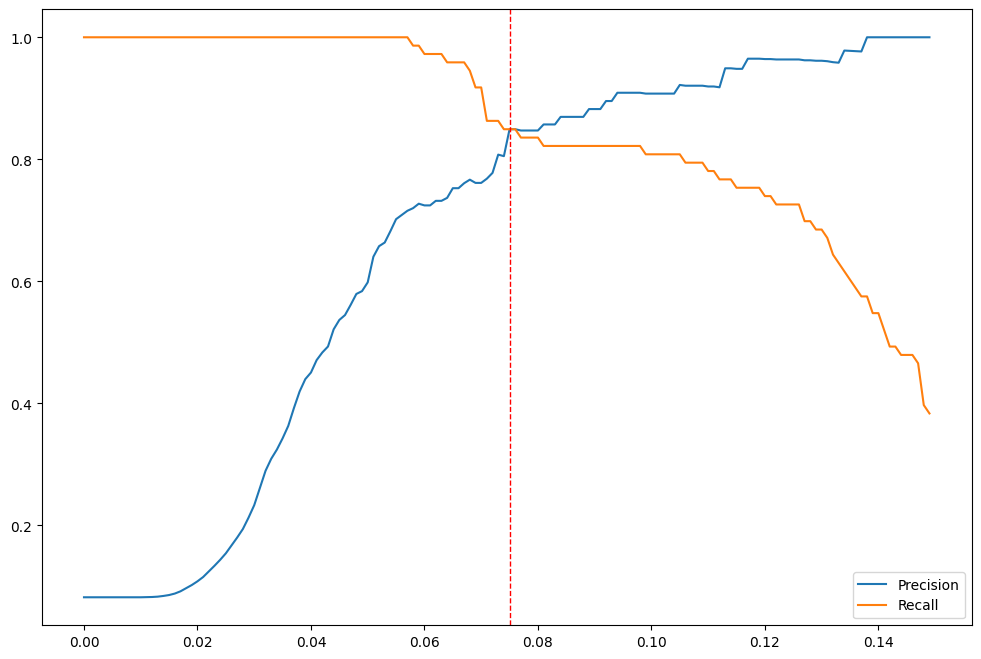

In [19]:
plt.figure(figsize=(12,8))
plt.plot(thresholds, precision_list, label = 'Precision')
plt.plot(thresholds, recall_list, label = 'Recall')
plt.axvline(first_threshold, color='red', linestyle='--', linewidth=1)
plt.legend()
plt.show()

## Second Model Threshold

In [20]:
val_down_loss = [0 for _ in range(len(val_down_dataset))]
val_abnormal_loss = [0 for _ in range(len(val_abnormal_dataset))]

with torch.no_grad():
    for i in range(len(val_down_dataset)):
        data = val_down_dataset[i]
        data = data.unsqueeze(0).to(device)
        output = second_model.forward(data).to(device)
        loss = criterion(data, output)
        val_down_loss[i] = loss

with torch.no_grad():
    for i in range(len(val_abnormal_dataset)):
        data = val_abnormal_dataset[i]
        data = data.unsqueeze(0).to(device)
        output = second_model.forward(data).to(device)
        loss = criterion(data, output)
        val_abnormal_loss[i] = loss

In [21]:
thresholds = np.arange(0, 0.15, 0.001)

accuracy_list = [0 for _ in range(len(thresholds))]
precision_list = [0 for _ in range(len(thresholds))]
recall_list = [0 for _ in range(len(thresholds))]
F1_list = [0 for _ in range(len(thresholds))]

for i in range(len(thresholds)):
    threshold = thresholds[i]
    val_abnomal = 0
    test_abnomal = 0
    
    for loss in val_down_loss:
        if loss > threshold:
            val_abnomal += 1
    
    for loss in val_abnormal_loss:
        if loss > threshold:
            test_abnomal += 1
            
    TP = test_abnomal
    FP = val_abnomal
    TN = len(val_normal_dataset)-val_abnomal
    FN = len(val_abnormal_dataset)-test_abnomal
    
    accuracy = (TP+TN) / (TP+FP+TN+FN)
    precision = TP / (TP+FP)
    recall = TP / (TP+FN)
    F1 = 2 / (1/precision + 1/recall)

    accuracy_list[i] = accuracy
    precision_list[i] = precision
    recall_list[i] = recall
    F1_list[i] = F1

In [22]:
min_dist = 10
idx = 0

for i in range(len(thresholds)):
    precision, recall = precision_list[i], recall_list[i]
    
    if min_dist > abs(precision-recall):
        min_dist, idx = abs(precision-recall), i
        
second_threshold = thresholds[idx]
print(second_threshold)

0.08940000000000001


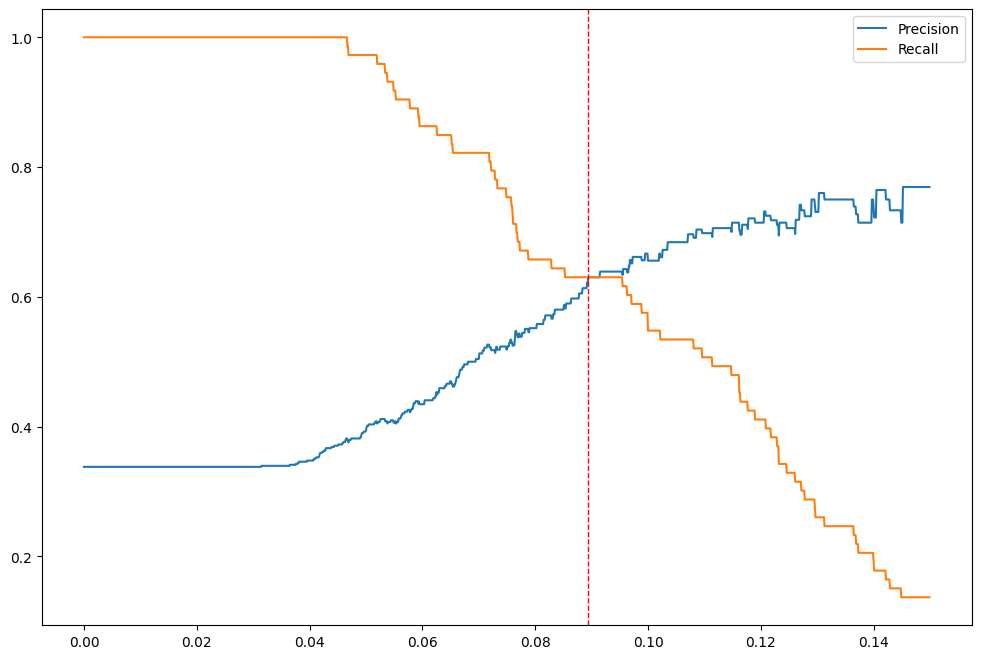

In [23]:
plt.figure(figsize=(12,8))
plt.plot(thresholds, precision_list, label = 'Precision')
plt.plot(thresholds, recall_list, label = 'Recall')
plt.axvline(second_threshold, color='red', linestyle='--', linewidth=1)
plt.legend()
plt.show()

In [24]:
print(f'Accuracy // Precision // Recall // F1-Score')
print(f'{accuracy_list[idx]} // {precision_list[idx]} // {recall_list[idx]} // {F1_list[idx]}')

Accuracy // Precision // Recall // F1-Score
0.939120631341601 // 0.6301369863013698 // 0.6301369863013698 // 0.6301369863013698


## Two-Stage

In [25]:
# 편의상 두 First, Second 두 모델 모두 Test Dataset에 대한 loss를 계산
first_normal_loss = [0 for _ in range(len(test_normal_dataset))]
first_down_loss = [0 for _ in range(len(test_down_dataset))]
first_abnormal_loss = [0 for _ in range(len(test_abnormal_dataset))]

second_normal_loss = [0 for _ in range(len(test_normal_dataset))]
second_down_loss = [0 for _ in range(len(test_down_dataset))]
second_abnormal_loss = [0 for _ in range(len(test_abnormal_dataset))]

# Normal Dataset
with torch.no_grad():
    for i in range(len(test_normal_dataset)):
        data = test_normal_dataset[i]
        data = data.unsqueeze(0).to(device)
        
        output = first_model.forward(data).to(device)
        loss = criterion(data, output)
        first_normal_loss[i] = loss
        
        output = second_model.forward(data).to(device)
        loss = criterion(data, output)
        second_normal_loss[i] = loss
        
# Down Dataset
with torch.no_grad():
    for i in range(len(test_down_dataset)):
        data = test_down_dataset[i]
        data = data.unsqueeze(0).to(device)
        
        output = first_model.forward(data).to(device)
        loss = criterion(data, output)
        first_down_loss[i] = loss
        
        output = second_model.forward(data).to(device)
        loss = criterion(data, output)
        second_down_loss[i] = loss

# Abnormal Dataset
with torch.no_grad():
    for i in range(len(test_abnormal_dataset)):
        data = test_abnormal_dataset[i]
        data = data.unsqueeze(0).to(device)
        
        output = first_model.forward(data).to(device)
        loss = criterion(data, output)
        first_abnormal_loss[i] = loss
        
        output = second_model.forward(data).to(device)
        loss = criterion(data, output)
        second_abnormal_loss[i] = loss

In [31]:
TP = 0
FP = 0
TN = 0
FN = 0

# Normal Data
for i in range(len(test_normal_dataset)):
    if first_normal_loss[i]>first_threshold:
        if second_normal_loss[i]>second_threshold:
            FP += 1
        else:
            TN += 1
    else:
        TN += 1
    
# Down Data
for i in range(len(test_down_dataset)):
    if first_down_loss[i]>first_threshold:
        if second_down_loss[i]>second_threshold:
            FP += 1
        else:
            TN += 1
    else:
        TN += 1

# Abnormal Data
for i in range(len(test_abnormal_dataset)):
    if first_abnormal_loss[i]>first_threshold:
        if second_abnormal_loss[i]>second_threshold:
            TP += 1
        else:
            FN += 1
    else:
        FN += 1

In [37]:
accuracy = (TP+TN) / (TP+FP+TN+FN)
precision = TP / (TP+FP)
recall = TP / (TP+FN)
F1 = 2 / (1/precision + 1/recall)

In [38]:
print(f'Accuracy // Precision // Recall // F1-Score')
print(f'{accuracy} // {precision} // {recall} // {F1}')

Accuracy // Precision // Recall // F1-Score
0.9593023255813954 // 0.6962025316455697 // 0.7534246575342466 // 0.7236842105263158
